In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
# Set seed for replayability
from numpy.random import seed 
seed(1)
import tensorflow as tf
tf.random.set_seed(2)
pd.options.mode.chained_assignment = None  # default='warn'


# <span style='font-family:"Times New Roman"'> <span styel=''>Data pre-processing

In [2]:
# Read data
df = pd.read_csv('NewCases_Data/export_dataframe.csv')
df


,date,newCasesByPublishDate,newDeaths28DaysByPublishDate,newAdmissions,hospitalCases,covidOccupiedMVBeds,London
0,2020-04-21,4301,1224,1713,19139,3036,0.09
1,2020-04-22,4451,847,1527,18533,2964,0.09
2,2020-04-23,4583,682,1513,17867,2867,0.09
3,2020-04-24,5386,1010,1525,17063,2703,0.09
4,2020-04-25,4913,815,1255,16604,2702,0.08
...,...,...,...,...,...,...,...
291,2021-02-06,18262,828,1880,26881,3373,0.21
292,2021-02-07,15845,373,1846,26767,3302,0.21
293,2021-02-08,14104,333,1909,26706,3230,0.24
294,2021-02-09,12364,1052,1743,25643,3164,0.22


In [3]:
df_data = df[['date','newCasesByPublishDate','newDeaths28DaysByPublishDate'
             ,'newAdmissions','hospitalCases','covidOccupiedMVBeds','London']]
df_data


,date,newCasesByPublishDate,newDeaths28DaysByPublishDate,newAdmissions,hospitalCases,covidOccupiedMVBeds,London
0,2020-04-21,4301,1224,1713,19139,3036,0.09
1,2020-04-22,4451,847,1527,18533,2964,0.09
2,2020-04-23,4583,682,1513,17867,2867,0.09
3,2020-04-24,5386,1010,1525,17063,2703,0.09
4,2020-04-25,4913,815,1255,16604,2702,0.08
...,...,...,...,...,...,...,...
291,2021-02-06,18262,828,1880,26881,3373,0.21
292,2021-02-07,15845,373,1846,26767,3302,0.21
293,2021-02-08,14104,333,1909,26706,3230,0.24
294,2021-02-09,12364,1052,1743,25643,3164,0.22


In [4]:
# Separate dates for future plotting
all_dates = pd.to_datetime(df_data['date'])

# Extract features
n_features = 6  
cols = list(df_data)[1:n_features + 1]
data = df_data[cols].astype(float)

# Split into the train set and the test set
split = 0.75
x = int(data.shape[0] * split)
train_set, test_set = data[:x], data[x:]
print("train set:", train_set.shape)
print("test set:", test_set.shape)


train set: (222, 6)
test set: (74, 6)


In [5]:
# Number of days predicted into the future
n_future = 1

# Number of past days used as the input
n_past = 4

# Normalize the train set
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
train_data_scaled = scaler.transform(train_set)

# Inverse scaling function
def inverse_scaling(data):
    data_copies = np.repeat(data, train_set.shape[1], axis=-1)
    data = scaler.inverse_transform(data_copies)[:, 0]
    return data

print("scaled train set:", train_data_scaled.shape)
print("scaled train set type:", type(train_data_scaled))


scaled train set: (222, 6)
scaled train set type: <class 'numpy.ndarray'>


In [6]:
# Reshape input and output
train_X, train_Y = [], []

for i in range(n_past, train_data_scaled.shape[0] - n_future + 1):
    train_X.append(train_data_scaled[i - n_past:i, 0:train_data_scaled.shape[1]])
    train_Y.append(train_data_scaled[i + n_future - 1:i + n_future, 0])

train_x, train_y = np.array(train_X), np.array(train_Y)

print("train x:", train_x.shape)
print("train y:", train_y.shape)


train x: (218, 4, 6)
train y: (218, 1)


# <span style='font-family:"Times New Roman"'> <span styel=''>Model training

In [7]:
# CNN-Bi-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# Training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='auto')
history = model.fit(train_x, train_y, epochs=45, batch_size=n_past-1, validation_split=0.1, verbose=1, callbacks=[reduce_lr])


Epoch 1/45
66/66 [==============================] - 1s 16ms/step - loss: 0.2368 - val_loss: 0.4134
Epoch 2/45
66/66 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.1572
Epoch 3/45
66/66 [==============================] - 0s 4ms/step - loss: 0.0308 - val_loss: 0.0589
Epoch 4/45
66/66 [==============================] - 0s 3ms/step - loss: 0.0286 - val_loss: 0.0520
Epoch 5/45
66/66 [==============================] - 0s 3ms/step - loss: 0.0223 - val_loss: 0.0618
Epoch 6/45
66/66 [==============================] - 0s 3ms/step - loss: 0.0201 - val_loss: 0.0614
Epoch 7/45
66/66 [==============================] - 0s 3ms/step - loss: 0.0188 - val_loss: 0.0702
Epoch 8/45
66/66 [==============================] - 0s 3ms/step - loss: 0.0176 - val_loss: 0.0538
Epoch 9/45
66/66 [==============================] - 0s 3ms/step - loss: 0.0176 - val_loss: 0.0544
Epoch 10/45
66/66 [==============================] - 0s 3ms/step - loss: 0.0167 - val_loss: 0.0541
Epoch 11/45
66/66 

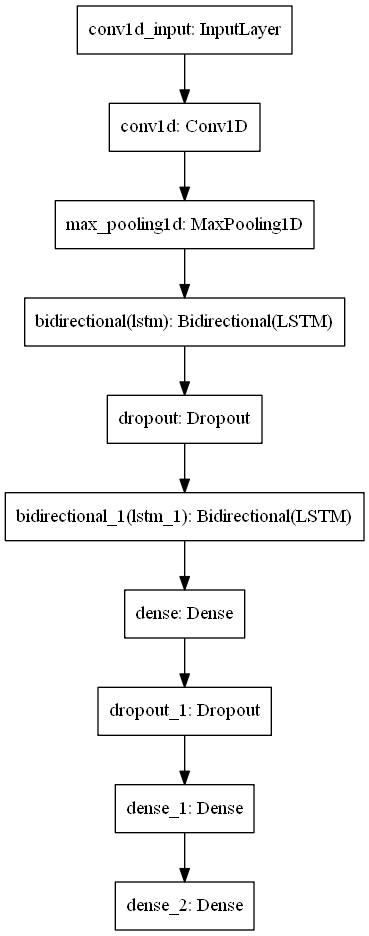

In [8]:
# Plot model
import os

os.environ["PATH"] += os.pathsep + 'd:\anaconda3\lib\site-packages'
from keras.utils.vis_utils import plot_model

# plot_model(model, to_file='cnn-bilstm_model.svg', dpi=None, show_shapes=False, show_layer_names=True)
plot_model(model, to_file='cnn-bilstm_model.png', show_shapes=False, show_layer_names=True)


# <span style='font-family:"Times New Roman"'> <span styel=''>Model validation

Text(0.5, 1.0, 'model train vs validation loss')

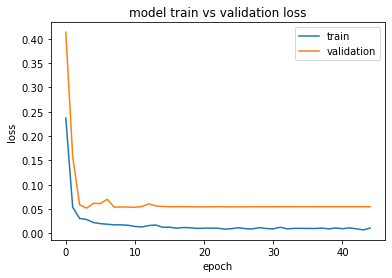

In [9]:
# Plot model train vs validation loss
sns.lineplot(data=history.history['loss'])
sns.lineplot(data=history.history['val_loss'])
plt.legend(labels=['train', 'validation'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("model train vs validation loss")

In [10]:
# Validation set
val_x, val_y = train_x[int(-0.1 * len(train_x)) - 1:], train_y[int(-0.1 * len(train_x)) - 1:]
results = model.evaluate(val_x, val_y)
p_val_y = model.predict(val_x)
val_y = inverse_scaling(val_y)
p_val_y = inverse_scaling(p_val_y)

# Persistence error correction on the validation set
resid = [val_y[i] - p_val_y[i] for i in range(len(p_val_y))]
persistence_predictions = []
for i in range(n_future):
    persistence_predictions.append(p_val_y[i])
for i in range(len(p_val_y) - n_future):
    correct_y = p_val_y[i + n_future] + resid[i]
    persistence_predictions.append(correct_y)

# Autoregression error correction on the validation set
x, y = train_x[:int(-0.1 * len(train_x)) - 1], train_y[:int(-0.1 * len(train_x)) - 1]
p_y = model.predict(x)
y = inverse_scaling(y)
p_y = inverse_scaling(p_y)

# Residuals of the train set
resid = [y[i] - p_y[i] for i in range(len(p_y))]
window = 1
model_reg = AutoReg(resid, lags=window, old_names=False)
model_fit = model_reg.fit()
coef = model_fit.params

# Predict residual errors
resid_history = resid[len(resid) - window - n_future + 1:]
reg_predictions = []
for t in range(len(val_y)):
    error = val_y[t] - p_val_y[t]
    length = len(resid_history)
    lag_error = [resid_history[i] for i in range(length - window - n_future + 1, length - n_future + 1)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d + 1] * lag_error[window - d - 1]
    correct_y = p_val_y[t] + pred_error
    reg_predictions.append(correct_y)
    resid_history.append(error)

print("original validation RMSE is", mean_squared_error(val_y, p_val_y, squared=False))
print("persistence validation RMSE is", mean_squared_error(val_y, persistence_predictions, squared=False))
print("autoregression validation RMSE is", mean_squared_error(val_y, reg_predictions, squared=False))


1/1 [==============================] - 0s 2ms/step - loss: 0.0548
original validation RMSE is 3878.626713256488
persistence validation RMSE is 3583.094480766337
autoregression validation RMSE is 3377.6078675810195


Text(0.5, 1.0, 'residual error correction')

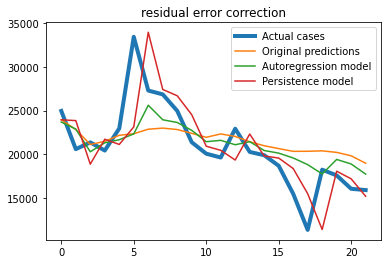

In [11]:
# Plot corrected validation performance
sns.lineplot(data=val_y, linewidth = 4)
sns.lineplot(data=p_val_y)
sns.lineplot(data=reg_predictions)
sns.lineplot(data=persistence_predictions)
plt.legend(labels=['Actual cases', 'Original predictions','Autoregression model','Persistence model'])
plt.title("residual error correction")


# <span style='font-family:"Times New Roman"'> <span styel=''>Model testing

In [12]:
# Reshape input and output
test_data_scaled = scaler.transform(test_set)
test_X, test_Y = [], []

for i in range(n_past, test_data_scaled.shape[0] - n_future + 1):
    test_X.append(test_data_scaled[i - n_past:i, 0:test_data_scaled.shape[1]])
    test_Y.append(test_data_scaled[i + n_future - 1:i + n_future, 0])

test_x, test_y = np.array(test_X), np.array(test_Y)

print("test x:", test_x.shape)
print("test y:", test_y.shape)


test x: (70, 4, 6)
test y: (70, 1)


3/3 [==============================] - 0s 2ms/step - loss: 0.1966


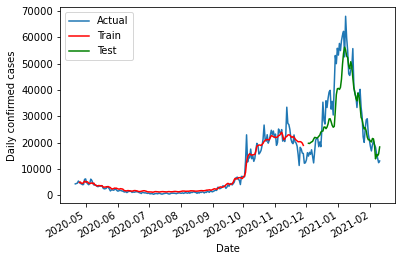

In [13]:
results = model.evaluate(test_x, test_y)
predict_y = model.predict(test_x)
model_y = model.predict(train_x)

model_y = inverse_scaling(model_y)
predict_y = inverse_scaling(predict_y)
test_y = inverse_scaling(test_y)
train_y = inverse_scaling(train_y)

# Model y for plotting
train_dates = all_dates[n_past + n_future - 1:n_past + n_future - 1 + train_y.shape[0]]
df_train = pd.DataFrame({'date': np.array(train_dates), 'newCasesByPublishDate': model_y})
df_train['date'] = pd.to_datetime(df_train['date'])

# Predict y for plotting
test_dates = all_dates.tail(predict_y.shape[0])
df_predict = pd.DataFrame({'date': np.array(test_dates), 'newCasesByPublishDate': predict_y})
df_predict['date'] = pd.to_datetime(df_predict['date'])

# Actual y for plotting
original = df[['date', 'newCasesByPublishDate']]
original['date'] = pd.to_datetime(original['date'])

# Plot
sns.lineplot(data=original, x="date", y="newCasesByPublishDate")
sns.lineplot(data=df_train, x="date", y="newCasesByPublishDate", color='red')
sns.lineplot(data=df_predict, x="date", y="newCasesByPublishDate", color='green')
plt.legend(labels=['Actual', 'Train', 'Test'])
plt.xlabel("Date")
plt.ylabel("Daily confirmed cases")
# changed the angle of datetimes
plt.gcf().autofmt_xdate()


persistence test RMSE is 5084.444280536351


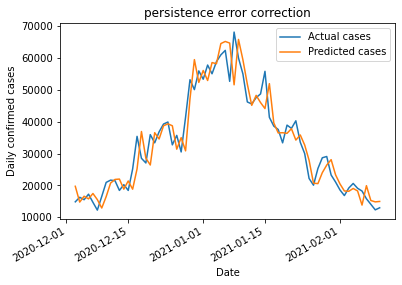

In [14]:
# Persistence error correction on the test set
resid = [test_y[i] - predict_y[i] for i in range(len(predict_y))]
persistence_predictions = []
for i in range(n_future):
    persistence_predictions.append(predict_y[i])
for i in range(len(predict_y) - n_future):
    correct_y = predict_y[i + n_future] + resid[i]
    persistence_predictions.append(correct_y)

print("persistence test RMSE is", mean_squared_error(test_y, persistence_predictions, squared=False))

# Plot
df_predict = pd.DataFrame({'date': np.array(test_dates), 'newCasesByPublishDate': persistence_predictions})
df_predict['date'] = pd.to_datetime(df_predict['date'])
original = pd.DataFrame({'date': np.array(test_dates), 'newCasesByPublishDate': test_y})
original['date'] = pd.to_datetime(original['date'])
sns.lineplot(data=original, x="date", y="newCasesByPublishDate")
sns.lineplot(data=df_predict, x="date", y="newCasesByPublishDate")
plt.legend(labels=['Actual cases', 'Predicted cases'])
plt.xlabel("Date")
plt.ylabel("Daily confirmed cases")
plt.title("persistence error correction")
plt.gcf().autofmt_xdate()


autoregression test RMSE is 5448.456184955639


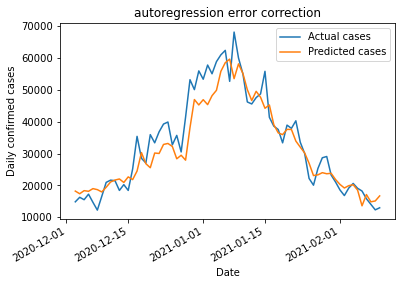

In [15]:
# Autoregression error correction on the test set
train_resid = [train_y[i] - model_y[i] for i in range(len(model_y))]
model_reg = AutoReg(train_resid, lags=window, old_names=False)
model_fit = model_reg.fit()
coef = model_fit.params

history = train_resid[len(train_resid) - window - n_future + 1:]
reg_predictions = []
for t in range(len(test_y)):
    error = test_y[t] - predict_y[t]
    length = len(history)
    lag_error = [history[i] for i in range(length - window - n_future + 1, length - n_future + 1)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d + 1] * lag_error[window - d - 1]
    correct_y = predict_y[t] + pred_error
    reg_predictions.append(correct_y)
    history.append(error)

print("autoregression test RMSE is", mean_squared_error(test_y, reg_predictions, squared=False))

# Plot
df_predict = pd.DataFrame({'date': np.array(test_dates), 'newCasesByPublishDate': reg_predictions})
df_predict['date'] = pd.to_datetime(df_predict['date'])
sns.lineplot(data=original, x="date", y="newCasesByPublishDate")
sns.lineplot(data=df_predict, x="date", y="newCasesByPublishDate")
plt.legend(labels=['Actual cases', 'Predicted cases'])
plt.xlabel("Date")
plt.ylabel("Daily confirmed cases")
plt.title("autoregression error correction")
plt.gcf().autofmt_xdate()


In [16]:
# Model by itself
print("test RMSE is", mean_squared_error(test_y, predict_y, squared=False))
print("test MAE is", mean_absolute_error(test_y, predict_y))
print("test r2 score is", r2_score(test_y, predict_y))

test RMSE is 7344.726139461862
test MAE is 5467.813406808035
test r2 score is 0.7669848626754676


In [17]:
# Persistence error correction
print("persistence correction RMSE is", mean_squared_error(test_y, persistence_predictions, squared=False))
print("persistence correction MAE is", mean_absolute_error(test_y, persistence_predictions))
print("persistence correction r2 score is", r2_score(test_y, persistence_predictions))

persistence correction RMSE is 5084.444280536351
persistence correction MAE is 3898.3244977678573
persistence correction r2 score is 0.8883342709838962


In [18]:
# Autoregression error correction
print("autoregression correction RMSE is", mean_squared_error(test_y, reg_predictions, squared=False))
print("autoregression correction MAE is", mean_absolute_error(test_y, reg_predictions))
print("autoregression correction r2 score is", r2_score(test_y, reg_predictions))

autoregression correction RMSE is 5448.456184955639
autoregression correction MAE is 3950.5664994143763
autoregression correction r2 score is 0.8717728922916359


##### 